# Setup

In [23]:
import create_models
from pathlib import Path
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Models

## Initialization

In [24]:
image_size = 64

mean_variance = create_models.mean_variance(
    image_size=image_size,
    num_channels=128,
    num_res_blocks=3,
    channel_mult="",
    learn_sigma=True,
    use_checkpoint=False,
    attention_resolutions="16,8",
    num_heads=4,
    num_head_channels=-1,
    num_heads_upsample=-1,
    use_scale_shift_norm=True,
    dropout=0.3,
    resblock_updown=False,
    use_fp16=True,
    use_new_attention_order=False,
)
diffusion = create_models.gaussian_diffusion(
    steps=1000,
    learn_sigma=True,
    sigma_small=False,
    noise_schedule="cosine",
    use_kl=False,
    predict_xstart=False,
    rescale_timesteps=False,
    rescale_learned_sigmas=False,
    timestep_respacing="100",
)
regressor = create_models.regressor(
    image_size=image_size,
    in_channels=1 + 3 + 2 + 2,
    regressor_use_fp16=False,
    regressor_width=128,
    regressor_depth=4,
    regressor_attention_resolutions="32,16,8",
    regressor_use_scale_shift_norm=True,
    regressor_resblock_updown=True,
    regressor_pool="spatial",
)
classifier = create_models.classifier(
    image_size=image_size,
    in_channels=1,
    classifier_use_fp16=False,
    classifier_width=128,
    classifier_depth=2,
    classifier_attention_resolutions="32,16,8",
    classifier_use_scale_shift_norm=True,
    classifier_resblock_updown=True,
    classifier_pool="attention",
)

## Loading Checkpoints

In [25]:
checkpoints_path = Path(r".\checkpoints")
cpu = torch.cpu.current_device()
gpu = torch.cuda.current_device()
def get_state_dict(path: Path):
    return torch.load(path, map_location=cpu, weights_only=True)

mean_variance_path = checkpoints_path / "diff_checkpoint" / "model_180000.pt"
mean_variance.load_state_dict(get_state_dict(mean_variance_path))
mean_variance.to(gpu)
mean_variance.convert_to_fp16()
mean_variance.eval()

regressor_path = checkpoints_path / "reg_checkpoint" / "model_350000.pt"
regressor.load_state_dict(get_state_dict(regressor_path))
regressor.to(gpu)
regressor.eval()

classifier_path = checkpoints_path / "class_checkpoint" / "model_299999.pt"
classifier.load_state_dict(get_state_dict(classifier_path))
classifier.to(gpu)
classifier.eval()

EncoderUNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(

# Sampling

In [26]:
batch_size = 1
channel_count = 1
shape = (batch_size, channel_count, image_size, image_size)

def cond_fn_1(x: torch.Tensor, time_steps: torch.Tensor):
    with torch.enable_grad():
        x_in = x.detach().requires_grad_()
        logits = regressor(x_in, time_steps)
        grad = torch.autograd.grad(logits.sum(), x_in)[0]
        return (-1) * grad[:,0,:,:].reshape(shape) * 4.0

def cond_fn_2(x: torch.Tensor, time_steps: torch.Tensor):
    with torch.enable_grad():
        x_in = x.detach().requires_grad_()
        logits: torch.Tensor = classifier(x_in, time_steps)
        log_probs = F.log_softmax(logits, dim=-1)
        selected = log_probs[range(len(logits)), 1]
        grad = torch.autograd.grad(selected.sum(), x_in)[0]
        return grad[:,0,:,:].reshape(shape) * 3.0


def get_boundary_condition(condition_name: str):
    folder = Path(r".\data\dataset_1_diff\test_data_level_1")
    path = folder / f"cons_{condition_name}_array_200.npy"
    ndarray = np.transpose(np.load(path), [2, 0, 1]).astype(np.float32)
    tensor = torch.unsqueeze(torch.as_tensor(ndarray), 0) # Add batch size dimension
    return tensor.to(gpu)

sample = diffusion.p_sample_loop(
    model=mean_variance,
    shape=shape,
    cons=get_boundary_condition("pf"),
    loads=get_boundary_condition("load"),
    BCs=get_boundary_condition("bc"),
    noise=None,
    clip_denoised=True,
    denoised_fn=None,
    cond_fn_1=cond_fn_1,
    cond_fn_2=cond_fn_2,
    model_kwargs={},
    device=gpu,
    progress=False,
)

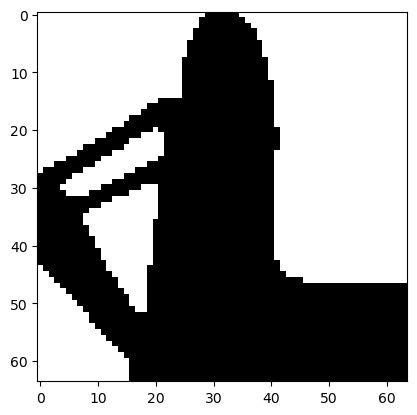

In [27]:
plt.imshow(sample[0,0,:,:].cpu().detach().numpy(), cmap="gray")